#Churn Prediction

##Módulo 5: Caso Práctico individual
###Alumno: 131044

![churn](http://chaotic-flow.com/wp-content/uploads/2017/09/saas-churn-leaky-bucket.png)

Este proyecto corresponde al módulo de Data Science del Master en Big Data Management. Por lo tanto, **el objetivo es el siguiente:** Poder predecir quien va a causar baja como cliente de una Telco en función de sus servicios contratados, tiempo en la compañía, facturación y tipos de contratos. 

Los datos a utilizar proceden de Kaggle (https://www.kaggle.com/blastchar/telco-customer-churn) y contienen información sobre clientes, productos y servicios contratados, información contractual, información método de pago y facturación, información permanencia clientes e información abandono de clientes.

La predicción se llevará a cabo estudiando previamente el dataset mediante un análisis exploratorio y la posterior elección del algoritmo ás adecuado para la solución del problema.

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
from google.colab import files
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

##  ACCESO A LOS DATOS

se han cargado en google collaboratory por lo que simplemente llamándolos con  la función read_csv() de pandas ya los tendríamos accesibles

In [0]:
#uploaded = files.upload()

In [0]:
churn_raw = pd.read_csv("churn.csv",sep=";",decimal=".")
churn_raw.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Después de un primer vistazo de los datos, revisamos si hay valores nulos y por tanto si requiere una limpieza el dataset

In [0]:
churn_raw.info()   #dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null float64
Churn               7043 non-null object
dtypes: float64(2), int64(2), ob

Ya que la función is.na() de R, detecta tanto los valores nulos como las celdas vacías, se ha decidido hacer una doble comprobación en R, ya que este tipo de valores caussarán errores en los siguientes pasos del proyecto.

**Input:** dataset %>% summarise_all(funs(sum(is.na(.))))

**output:**
TotalCharges = 11
Resto de Variables = 0

R detecta 11 NAs en la columna "TotalCharges" mientras que en Python no existe ningún valor nulo en esta viariable. Por  lo tanto,  pordríamos asumir que esos NAs corresponden a celdas vacías. En este caso, esos 11 clientes son nuevos y no tienen ninguna cuota pagada,ya que ternure para esos valores es 0 por lo tanto tendría sentido que estén vacíos aun, pero para que no nos de errores en los siguientes pasos se le asigna el valor 0.

In [0]:
#churn_raw.TotalCharges = pd.to_numeric(churn_raw.TotalCharges, errors='coerce')
#churn_raw.info()

In [0]:
churn_raw.describe(percentiles=[0.2,0.4,0.6,0.8], include=['object','float','int'])

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,7043,7043,7043.000000,7043,7043,7043.000000,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043.000000,7043.000000,7043
unique,7043,2,NaN,2,2,NaN,2,3,3,3,3,3,3,3,3,3,2,4,NaN,NaN,2
top,0687-ZVTHB,Male,NaN,No,No,NaN,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,NaN,NaN,No
freq,1,3555,NaN,3641,4933,NaN,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,NaN,NaN,5174
mean,NaN,NaN,0.162147,NaN,NaN,32.371149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,2279.734304,NaN
std,NaN,NaN,0.368612,NaN,NaN,24.559481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,2266.794470,NaN
min,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,0.000000,NaN
20%,NaN,NaN,0.000000,NaN,NaN,6.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.050000,265.320000,NaN
40%,NaN,NaN,0.000000,NaN,NaN,20.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58.830000,939.780000,NaN
50%,NaN,NaN,0.000000,NaN,NaN,29.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,1394.550000,NaN


Convertimos la variable customerID en el índice del dataset

In [0]:
churn_raw = churn_raw.set_index('customerID')

Separamos el dataset en variables  compuestas por valores de tipo númerico ya sea integer o float y por otro lado las variables cuyos valores son de tipo string. La variable 'SeniorCitizen' es numérica pero sin embargo es categórica.

In [0]:
churn_num = churn_raw[['SeniorCitizen', 'tenure', 'MonthlyCharges','TotalCharges']].copy()
churn_num.head()
columns = ['gender','Partner','Dependents','PhoneService','MultipleLines','InternetService','OnlineSecurity',
           'OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract',
           'PaperlessBilling','PaymentMethod','Churn']
churn_categorical = churn_raw[columns].copy()
churn_categorical.head()

,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
customerID,,,,,,,,,,,,,,,,
7590-VHVEG,Female,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,No
5575-GNVDE,Male,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,No
3668-QPYBK,Male,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,Yes
7795-CFOCW,Male,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),No
9237-HQITU,Female,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,Yes


En el siguiente paso, se crean columnas de formato binario para cada valor categórico y se eliminan las columnas que duplican la información

In [0]:
df = pd.get_dummies(data=churn_categorical, sparse=False, columns=columns)
churn_cat = df.drop(['gender_Male','Partner_No','Dependents_No','PhoneService_No','PaperlessBilling_No','Churn_No','MultipleLines_No',
                    'MultipleLines_No phone service','OnlineSecurity_No internet service','OnlineBackup_No internet service',
                     'DeviceProtection_No internet service','TechSupport_No internet service','StreamingTV_No internet service',
                     'StreamingMovies_No internet service','OnlineSecurity_No','OnlineBackup_No','DeviceProtection_No','TechSupport_No',
                     'StreamingTV_No','StreamingMovies_No'], axis =1)

churn_cat.head()

,gender_Female,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
customerID,,,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0
5575-GNVDE,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0
3668-QPYBK,0,0,0,1,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,1,1
7795-CFOCW,0,0,0,0,0,1,0,0,1,0,1,1,0,0,0,1,0,0,1,0,0,0,0
9237-HQITU,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1


# Distribución de variables

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f67fd378b70>,
      dtype=object)

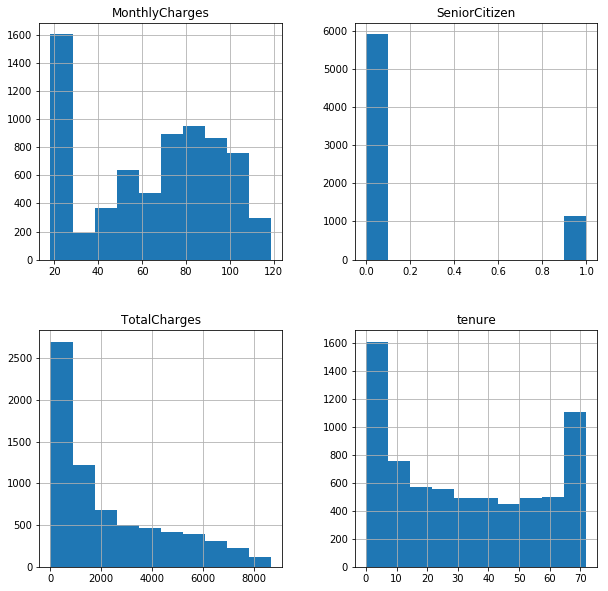

In [0]:
churn_num.hist(figsize=[10,10])

In [0]:
churn_cat.hist(figsize=[15,10])

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

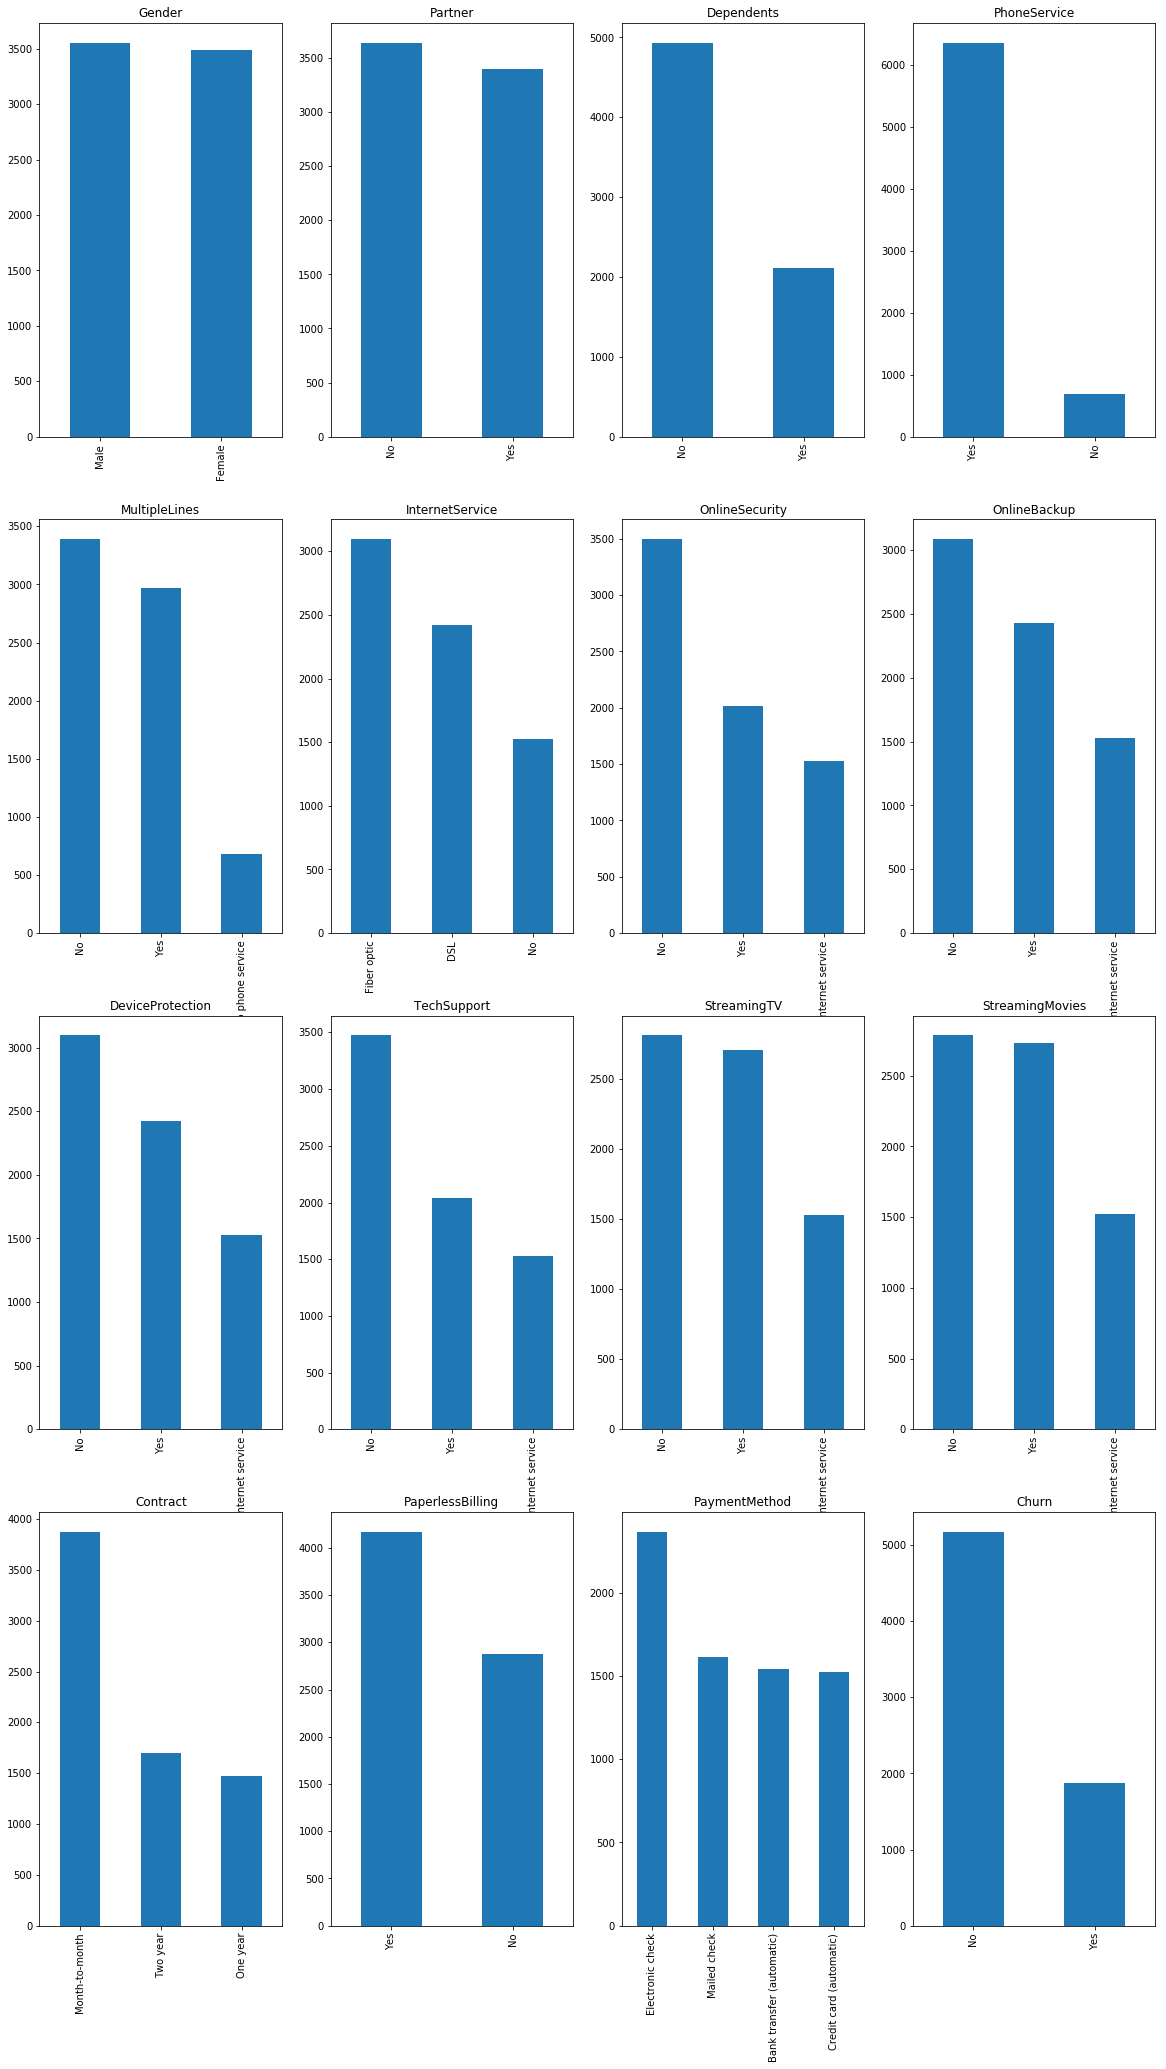

In [0]:
fig, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8),(ax9,ax10,ax11,ax12),(ax13,ax14,ax15,ax16)) = plt.subplots(4,4, figsize=(20,35))  # 1 row, 2 columns

churn_categorical.gender.value_counts().plot(kind='bar',title='Gender', ax=ax1)
churn_categorical.Partner.value_counts().plot(kind='bar',title='Partner', ax=ax2)
churn_categorical.Dependents.value_counts().plot(kind='bar',title='Dependents', ax=ax3)
churn_categorical.PhoneService.value_counts().plot(kind='bar',title='PhoneService', ax=ax4)
churn_categorical.MultipleLines.value_counts().plot(kind='bar',title='MultipleLines', ax=ax5)
churn_categorical.InternetService.value_counts().plot(kind='bar',title='InternetService', ax=ax6)
churn_categorical.OnlineSecurity.value_counts().plot(kind='bar',title='OnlineSecurity', ax=ax7)
churn_categorical.OnlineBackup.value_counts().plot(kind='bar',title='OnlineBackup', ax=ax8)
churn_categorical.DeviceProtection.value_counts().plot(kind='bar',title='DeviceProtection', ax=ax9)
churn_categorical.TechSupport.value_counts().plot(kind='bar',title='TechSupport', ax=ax10)
churn_categorical.StreamingTV.value_counts().plot(kind='bar',title='StreamingTV', ax=ax11)
churn_categorical.StreamingMovies.value_counts().plot(kind='bar',title='StreamingMovies', ax=ax12)
churn_categorical.Contract.value_counts().plot(kind='bar',title='Contract', ax=ax13)
churn_categorical.PaperlessBilling.value_counts().plot(kind='bar',title='PaperlessBilling', ax=ax14)
churn_categorical.PaymentMethod.value_counts().plot(kind='bar',title='PaymentMethod', ax=ax15)
churn_categorical.Churn.value_counts().plot(kind='bar',title='Churn', ax=ax16)


plt

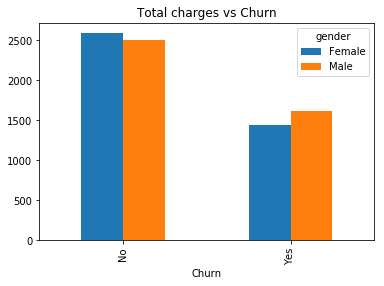

In [0]:
df = churn_raw.groupby(['gender','Churn']).mean().reset_index().pivot(index='Churn',columns='gender',values='TotalCharges')
df.plot(kind='bar', title='Total charges vs Churn')

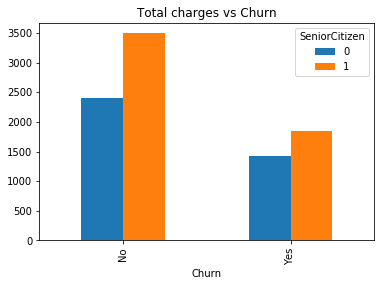

In [0]:
df = churn_raw.groupby(['SeniorCitizen','Churn']).mean().reset_index().pivot(index='Churn',columns='SeniorCitizen',values='TotalCharges')
df.plot(kind='bar', title='Total charges vs Churn')

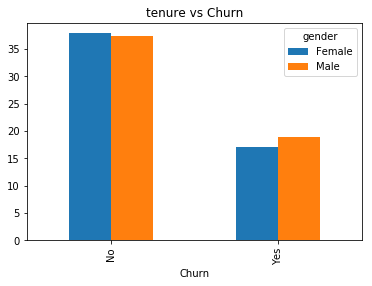

In [0]:
df = churn_raw.groupby(['gender','Churn']).mean().reset_index().pivot(index='Churn',columns='gender',values='tenure')
df.plot(kind='bar', title='tenure vs Churn')

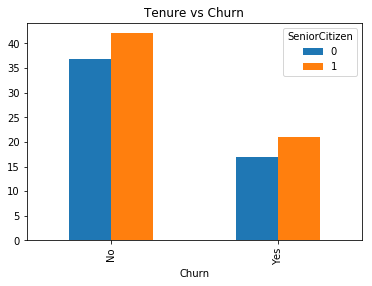

In [0]:
df = churn_raw.groupby(['SeniorCitizen','Churn']).mean().reset_index().pivot(index='Churn',columns='SeniorCitizen',values='tenure')
df.plot(kind='bar', title='Tenure vs Churn')

In [0]:
churn = churn_num.join(churn_cat)
#churn.head()

# Correlación de variables



<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

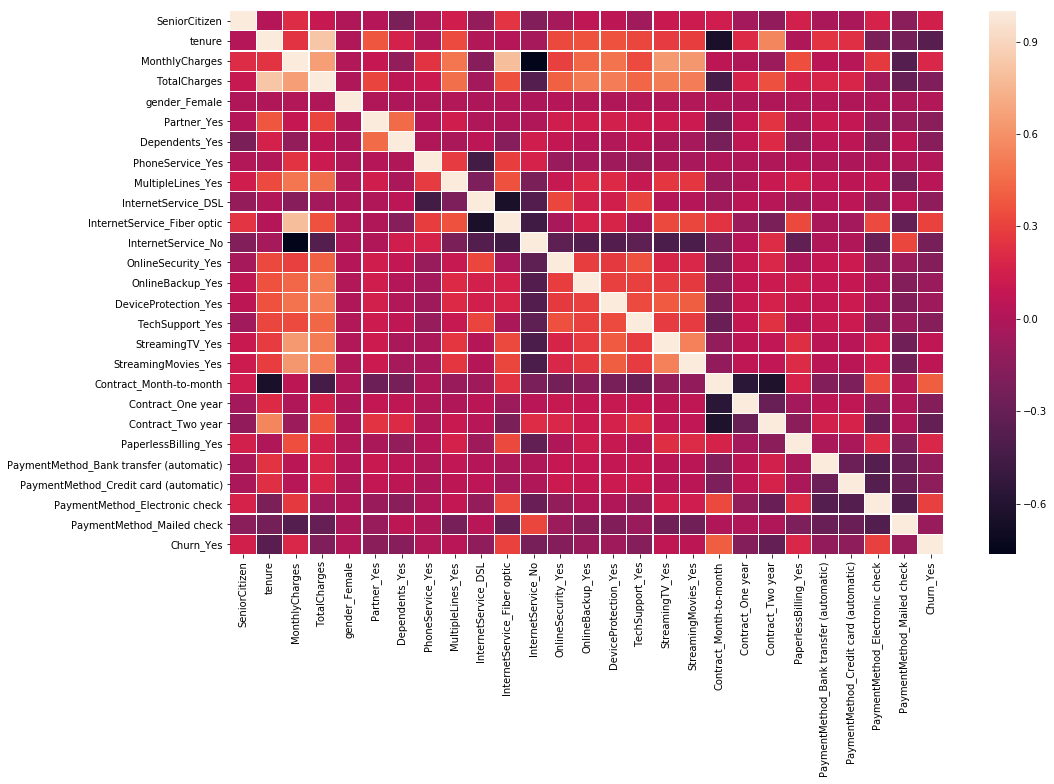

In [0]:
%matplotlib inline

# calculate the correlation matrix
corr = churn.corr()

# plot the heatmap

plt.figure(figsize = (16,10))

ax = sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns, linewidths=.2)

plt

Como se obseva en la anterior gráfica, las variables Ternure, TotalCharges y MonthlyCharge son las mas interesantes para estudiar más en detalle, estas no están excesivamente correladas y serán muy adecuadas para incluir en el modelo.

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

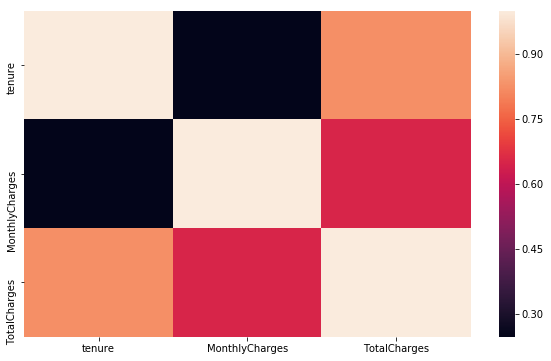

In [0]:
%matplotlib inline
# calculate the correlation matrix
corr = churn_num.drop(['SeniorCitizen'], axis=1).corr()

# plot the heatmap
plt.figure(figsize = (10,6))

ax = sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns)

plt

# MODELIZACIÓN

Para realizar la predicción se han escogido dos algoritmos supervisados:

*  Logical Regresion: ya que es el algoritmo que aporta mejores resultados para predicciones binarias
*   Random Forest: ya que es interesante comparar el anterior con un modelo avanzado que pruebe distintas posibilidades, como es Random Forest


In [0]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from scipy.spatial import ConvexHull

In [0]:
labels = np.array(churn['Churn_Yes'])
dffeatures = churn.drop('Churn_Yes',axis=1)
feature_list = list(churn.columns)
features =np.array(dffeatures)
dffeatures.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
customerID,,,,,,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,0,1,29.85,29.85,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0
5575-GNVDE,0,34,56.95,1889.50,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1
3668-QPYBK,0,2,53.85,108.15,0,0,0,1,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,1
7795-CFOCW,0,45,42.30,1840.75,0,0,0,0,0,1,0,0,1,0,1,1,0,0,0,1,0,0,1,0,0,0
9237-HQITU,0,2,70.70,151.65,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0


In [0]:
 #random forest
  
#@title Random Forest Implementation
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.3, random_state = 42)
rf = RandomForestClassifier(n_estimators = 20, random_state = 42)
rf.fit(train_features, train_labels);
predictions = rf.predict(test_features)

print("Train Accuracy :: " + str(accuracy_score(train_labels, rf.predict(train_features))))
print("Test Accuracy  :: " + str(accuracy_score(test_labels, predictions)))

Train Accuracy :: 0.9920892494929006
Test Accuracy  :: 0.791292001893043


In [0]:
#Feature importance

featureImportance = pd.concat([pd.Series(feature_list), pd.Series(rf.feature_importances_)],axis=1)
featureImportance

,0,1
0,SeniorCitizen,0.018493
1,tenure,0.159859
2,MonthlyCharges,0.169382
3,TotalCharges,0.182506
4,gender_Female,0.026947
5,Partner_Yes,0.024844
6,Dependents_Yes,0.018916
7,PhoneService_Yes,0.006105
8,MultipleLines_Yes,0.020951
9,InternetService_DSL,0.011239


In [0]:
#Random Forest reducing variables
labels_reduced = np.array(churn['Churn_Yes'])
dffeatures = churn[['tenure', 'MonthlyCharges','TotalCharges','InternetService_Fiber optic','gender_Female',
                    'Contract_Two year','Contract_One year']].copy()
feature_list_reduced = list(churn.columns)
features_reduced =np.array(dffeatures)
dffeatures.head()

#
train_features, test_features, train_labels, test_labels = train_test_split(features_reduced, labels_reduced, test_size = 0.3, random_state = 42)
rf = RandomForestClassifier(n_estimators = 15, random_state = 42)
rf.fit(train_features, train_labels);
predictions = rf.predict(test_features)

print("Train Accuracy :: " + str(accuracy_score(train_labels, rf.predict(train_features))))
print("Test Accuracy  :: " + str(accuracy_score(test_labels, predictions)))

Train Accuracy :: 0.9837728194726166
Test Accuracy  :: 0.7742546142924751


In [49]:
#logistic regresion
lr = LogisticRegression(random_state = 42)
lr.fit(train_features, train_labels);
predictions = lr.predict(test_features)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [50]:
print("Accuracy of LogisticRegression")
print("Train :: " + str(accuracy_score(train_labels, lr.predict(train_features))))
print("Test  :: " + str(accuracy_score(test_labels, predictions)))

Accuracy of LogisticRegression
Train :: 0.7880324543610547
Test  :: 0.7950780880265026


In [0]:
#@title Grid Search and Cross-Validation
param_grid = {
    'bootstrap': [True],
    'max_depth': [50, 60, 80],
    'max_features': [3,4,5,6,7],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [3, 5, 10, 100]
}
rf = RandomForestClassifier(random_state = 42)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 2)
grid_search.fit(train_features, train_labels)
grid_search.best_params_

Fitting 5 folds for each of 540 candidates, totalling 2700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done 690 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1256 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1986 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 2700 out of 2700 | elapsed:  6.1min finished


{'bootstrap': True,
 'max_depth': 50,
 'max_features': 3,
 'min_samples_leaf': 4,
 'min_samples_split': 8,
 'n_estimators': 100}

In [48]:
#title Model Accuracy Metrics
best_grid = grid_search.best_estimator_
predictions = best_grid.predict(test_features)

print("Accuracy of RandomForest")
print("Train:: " + str(accuracy_score(train_labels, best_grid.predict(train_features))))
print("Test:: " + str(accuracy_score(test_labels, predictions)))

Accuracy of RandomForest
Train:: 0.8829614604462475
Test:: 0.7969711310932324


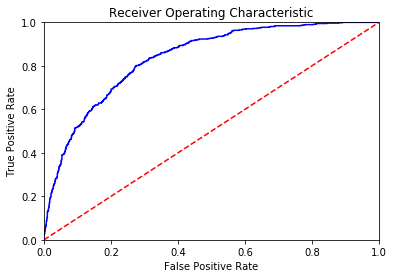

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

probs = best_grid.predict_proba(test_features)

fpr, tpr, threshold = roc_curve(test_labels, probs[:,1])
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [0]:
#@title Making Prediction Over Entire Dataset

dfEvaluate = churn[['tenure', 'MonthlyCharges','TotalCharges','InternetService_Fiber optic','gender_Female',
                    'Contract_Two year','Contract_One year']].copy()
#churn.copy()

evalFeatures = dfEvaluate #.drop('Churn_Yes', axis = 1)

eature_list_eval = list(evalFeatures.columns)
evalFeatures = np.array(evalFeatures)

#Make Predictions
evalPredictions = best_grid.predict(evalFeatures)
evalPredictions = best_grid.predict(evalFeatures)
dfEvaluate['PredictedChurn'] = evalPredictions


In [0]:
dfchurn = churn[['Churn_Yes']].copy()
df = dfEvaluate.join(dfchurn)
df.head()

,tenure,MonthlyCharges,TotalCharges,InternetService_Fiber optic,gender_Female,Contract_Two year,Contract_One year,PredictedChurn,Churn_Yes
customerID,,,,,,,,,
7590-VHVEG,1,29.85,29.85,0,1,0,0,0,0
5575-GNVDE,34,56.95,1889.50,0,0,0,1,0,0
3668-QPYBK,2,53.85,108.15,0,0,0,0,1,1
7795-CFOCW,45,42.30,1840.75,0,0,0,1,0,0
9237-HQITU,2,70.70,151.65,1,1,0,0,1,1


In [0]:
check = df.drop(['tenure', 'MonthlyCharges','TotalCharges','InternetService_Fiber optic','gender_Female',
                    'Contract_Two year','Contract_One year'],axis = 1)
check.head()
check['result'] = np.where(df['PredictedChurn'] == df['Churn_Yes'], 'Correct', 'InCorrect')
check['True_positive'] = np.where((df['PredictedChurn'] == 1) & (df['Churn_Yes'] ==1), 1, 0)
check['False_positive'] = np.where((df['PredictedChurn'] == 1) & (df['Churn_Yes'] ==0), 1, 0)
check['True_negative'] = np.where((df['PredictedChurn'] == 0) & (df['Churn_Yes'] ==0), 1, 0)
check['False_negative'] = np.where((df['PredictedChurn'] == 0) & (df['Churn_Yes'] ==1), 1, 0)
print('True positives =', (check.True_positive.sum()/7043).round(4))
print('False positives =',(check.False_positive.sum()/7043).round(4))
print('True negatives =',(check.True_negative.sum()/7043).round(4))
print('False negatives =',(check.False_negative.sum()/7043).round(4))

True positives = 0.1643
False positives = 0.0417
True negatives = 0.6929
False negatives = 0.1011


In [0]:
dfprecision = check.groupby(['result']).agg({'result': 'count'})
dfprecision

,result
result,
Correct,6037
InCorrect,1006


In [0]:
dfprecision['result'][0]/(dfprecision['result'][0]+dfprecision['result'][1]) * 100


85.7163140707085

# CONCLUSIÓN

Con ambos modelos se ha coseguido un buen resultado, pero el del RandomForest es ligeramente superior,  por lo que se selecciona dicho algoritmo como mejor opción para lograr el resultado.

Además en el tuneado del modelo,  se implementa cross validation y grid search y  se consigue un accuracy aún mejor, llegando al 0.7969711310932324.

Concluimos con un 85% de aciertos en la predicción de tasa de abandono.